In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)

sns.set(style="whitegrid")


In [ ]:
# Load dataset
df = pd.read_csv("data/heart_disease_cleveland_clean.csv")  

X = df.drop("target", axis=1)
y = df["target"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Load preprocessor
preprocessor = joblib.load(r"C:\Users\moham\miniconda3\envs\heart_ml\models\final_pipeline.pkl")


In [4]:
models = {
    "Logistic Regression": LogisticRegression(solver="liblinear", max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}


In [5]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("clf", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else pipe.decision_function(X_test)

    # metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        "pipeline": pipe,
        "report": report,
        "auc": auc
    }

    print(f"\n{name} Results:")
    print("AUC:", auc)
    print(classification_report(y_test, y_pred))



Logistic Regression Results:
AUC: 0.9408482142857143
              precision    recall  f1-score   support

           0       0.78      0.91      0.84        32
           1       0.87      0.71      0.78        28

    accuracy                           0.82        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.82      0.82      0.81        60


Decision Tree Results:
AUC: 0.7633928571428572
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        32
           1       0.77      0.71      0.74        28

    accuracy                           0.77        60
   macro avg       0.77      0.76      0.76        60
weighted avg       0.77      0.77      0.77        60


Random Forest Results:
AUC: 0.9341517857142858
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                    

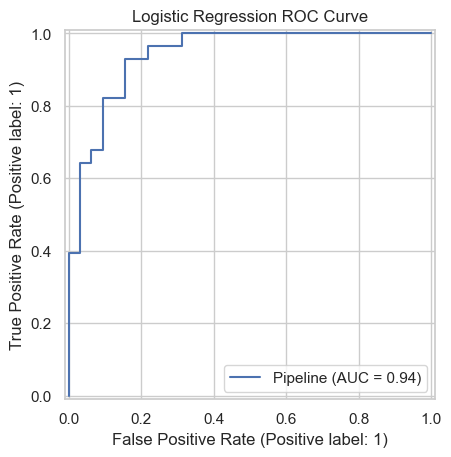

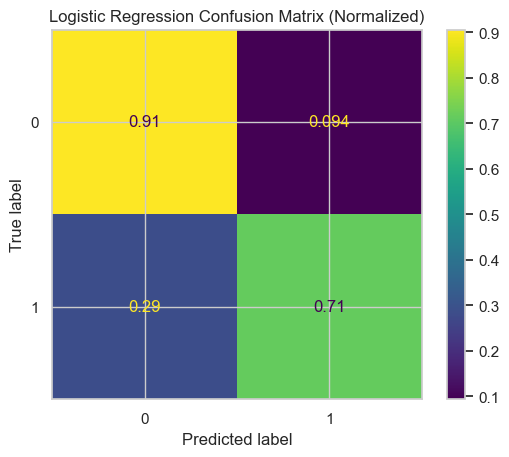

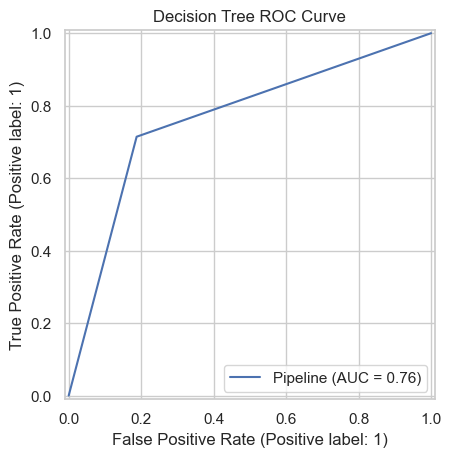

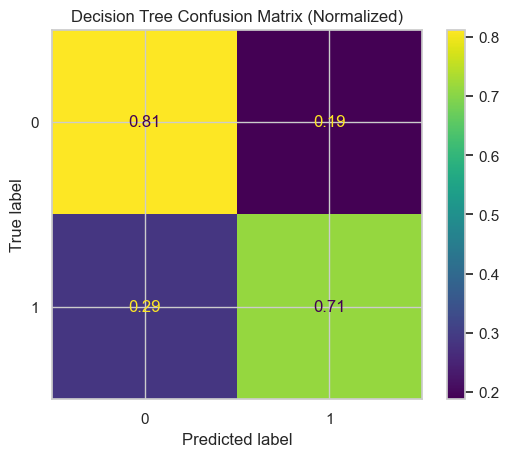

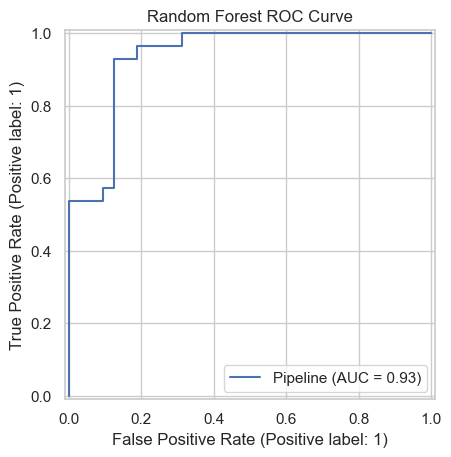

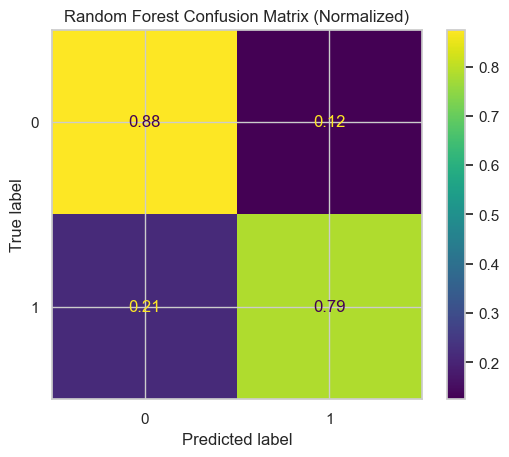

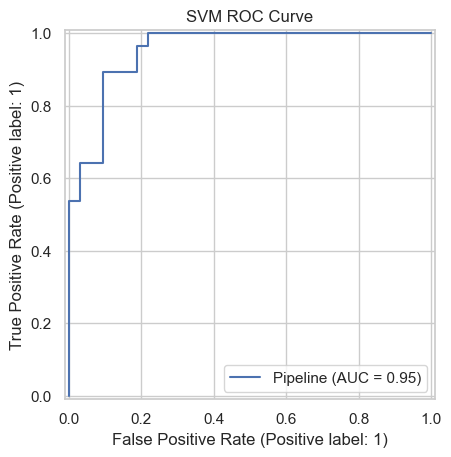

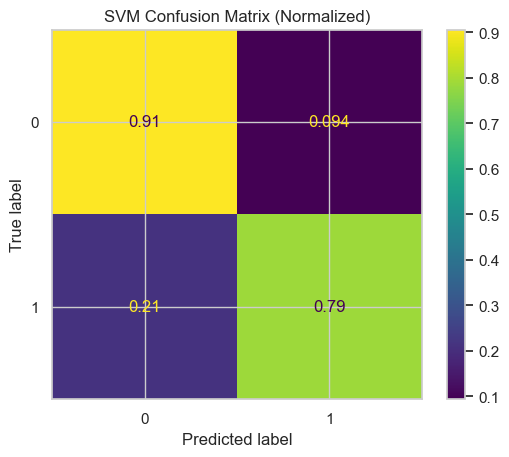

In [6]:
for name, res in results.items():
    pipe = res["pipeline"]

    # ROC curve
    RocCurveDisplay.from_estimator(pipe, X_test, y_test)
    plt.title(f"{name} ROC Curve")
    plt.show()

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, normalize="true")
    plt.title(f"{name} Confusion Matrix (Normalized)")
    plt.show()


In [8]:
best_model_name = max(results, key=lambda x: results[x]["auc"])
best_model = results[best_model_name]["pipeline"]

joblib.dump(best_model, r"C:\Users\moham\miniconda3\envs\heart_ml\models/best_supervised_model.pkl")
print(f"Best model saved: {best_model_name}")


Best model saved: SVM


In [10]:
with open(r"C:\Users\moham\miniconda3\envs\heart_ml\results\evaluation_metrics.txt", "a") as f:
    f.write("\n--- Supervised Learning ---\n")
    for name, res in results.items():
        f.write(f"\n{name}\n")
        f.write(f"AUC: {res['auc']:.3f}\n")
        f.write(pd.DataFrame(res["report"]).to_string())
        f.write("\n")
